# pyckmeans

pyckmeans is a Python package for [Consensus K-Means clustering](https://doi.org/10.1023/A:1023949509487), especially in the context of DNA sequence data. In addition to the clustering functionality, it provides tools for working with DNA sequence data such as reading and writing of DNA alignment files, calculating genetic distances, and Principle Coordinate Analysis (PCoA) for dimensionality reduction.


## Documentation

See pyckmeans' [RTD Documentation](https://pyckmeans.readthedocs.io/) for details.

## Installation

pyckmeans can be installed using pip, Conda, or from source.

### pip

```bash
pip install pyckmeans
```

### Conda

```bash
conda install pyckmeans -c TankredO
```

### From Source

The installation from source requires `git` and a c++ compiler.

```bash
git clone https://github.com/TankredO/pyckmeans
cd pyckmeans
pip install .
```



## Usage

### Clustering a Data Matrix (Single K)

Bayesian Information Criterion: 50.21824821939818
Davies-Bouldin Index: 0.2893792767901513
Silhouette Score: 0.7827738719266039
Calinski-Harabasz Index: 630.8235586596012
Cluster Membership: [0 2 1 0 2 2 1 0 2 1 0 0 2 0 2 2 1 1 1 1 0 1 2 2 2 2 1 0 2 2 1 0 1 1 0 0 0
 1 0 1 2 1 2 2 1 0 0 0 0 1]


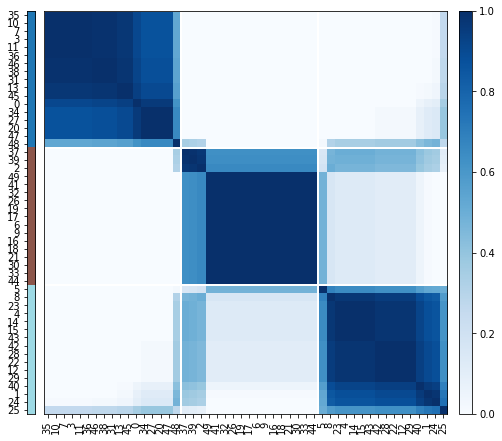

In [1]:
from pyckmeans import CKmeans

# simulate dataset
# 50 samples, 2 features, 3 true clusters
import sklearn.datasets
x, _ = sklearn.datasets.make_blobs(n_samples=50, n_features=2, centers=3, random_state=75)

# apply Consensus K-Means
# 3 clusters, 100 K-Means runs,
# draw 80% of samples and 50% of features for each single K-Means
ckm = CKmeans(k=3, n_rep=100, p_samp=0.8, p_feat=0.5)
ckm.fit(x)
ckm_res = ckm.predict(x)

# plot consensus matrix and consensus clustering
fig = ckm_res.plot(figsize=(7,7))

# consensus matrix
ckm_res.cmatrix

# clustering metrics
print('Bayesian Information Criterion:', ckm_res.bic)
print('Davies-Bouldin Index:', ckm_res.db)
print('Silhouette Score:', ckm_res.sil)
print('Calinski-Harabasz Index:', ckm_res.ch)

# consensus clusters
print('Cluster Membership:', ckm_res.cl)

### Clustering a Data Matrix (Multi K)

Metrics:
   k       sil         bic        db          ch
0  2  0.574369  225.092100  0.646401   59.733498
1  3  0.788207  126.358519  0.302979  387.409107
2  4  0.577967  127.299348  1.055452  269.192657
3  5  0.354507  128.411060  1.456013  209.530690


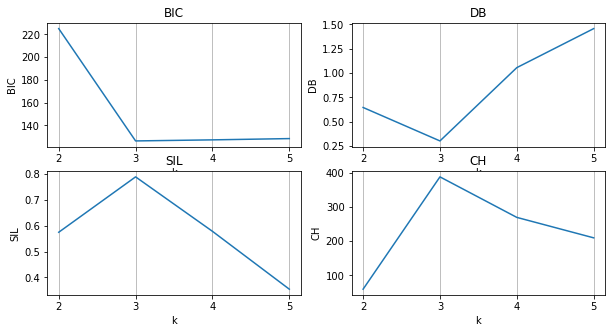

In [2]:
from pyckmeans import MultiCKMeans
import sklearn.datasets

# simulate dataset
# 50 samples, 10 features, 3 true clusters
x, _ = sklearn.datasets.make_blobs(n_samples=50, n_features=10, centers=3, random_state=44)

# apply multiple Consensus K-Means for
# k = 2, ..., 5
# 100 K-Means runs per Consensus K-Means
# draw 80% of the sample for each single K-Means
# draw 50% of the features for each single K-Means
mckm = MultiCKMeans(k=[2, 3, 4, 5], n_rep=100, p_samp=0.8, p_feat=0.5)
mckm.fit(x)
mckm_res = mckm.predict(x)

# clustering metrics
print('Metrics:')
print(mckm_res.metrics)

# plot clustering metrics against k
# BIC, DB: lower is better
# SIL, CH: higher is better
mckm_res.plot_metrics(figsize=(10,5))


# get a single CKmeansResult                  0 |1| 2  3
ckm_res_k3 = mckm_res.ckmeans_results[1] # k=[2, 3, 4, 5]
# ...
# see "Clustering a Data Matrix (Single K)"

### Clustering Sequence Data

Nucleotide alignment: <NucleotideAlignment; #samples: 108, #sites: 6752>
Eigenvalues:


,eigvals,eigvals_rel,eigvals_rel_cum,eigvals_rel_corrected,eigvals_rel_corrected_cum
0,0.115972,0.471458,0.233986,0.233986,0.233986
1,0.039585,0.160924,0.317016,0.083030,0.317016
2,0.035079,0.142604,0.391140,0.074125,0.391140
3,0.017383,0.070665,0.430295,0.039154,0.430295
4,0.009831,0.039965,0.454525,0.024230,0.454525
...,...,...,...,...,...
103,-0.001325,-0.005388,0.998575,0.001457,0.998575
104,-0.001693,-0.006881,0.999654,0.001079,0.999654
105,-0.001884,-0.007660,1.000000,0.000346,1.000000
106,-0.002255,-0.009168,1.000000,0.000000,1.000000


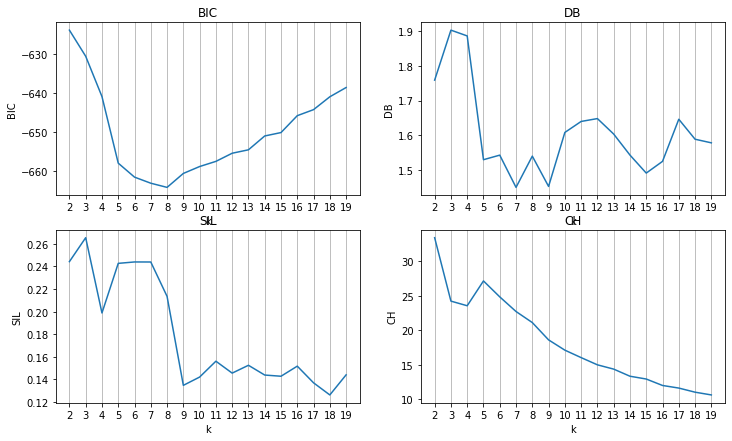

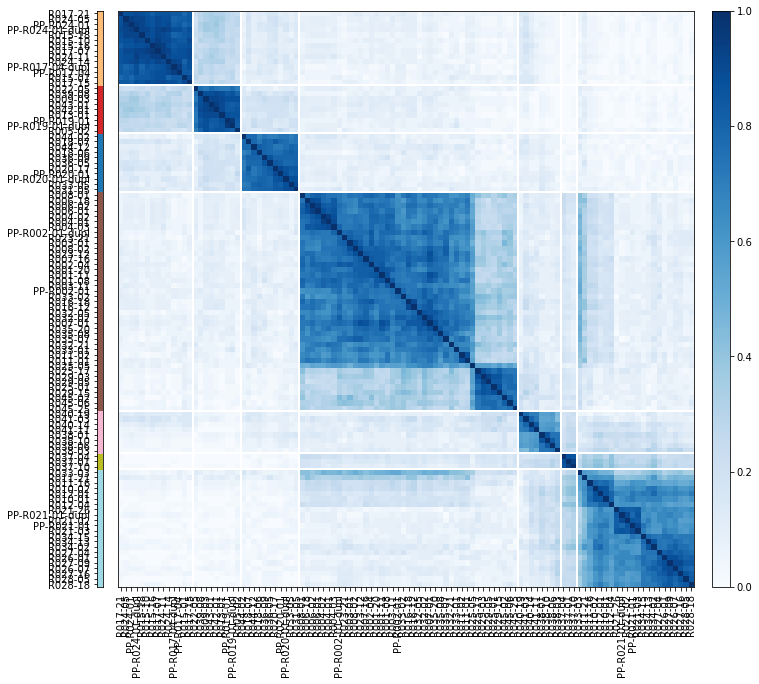

In [3]:
from pyckmeans import MultiCKMeans, NucleotideAlignment, pcoa
from IPython.display import display
# Set random seed for demonstration
import numpy
numpy.random.seed(0)

# Load nucleotide alignment
# Note: the file is available from
# "https://github.com/TankredO/pyckmeans/tree/main/docs/datasets/rhodanthemum_ct85_msl68.snps.phy"
aln = NucleotideAlignment.from_file('datasets/rhodanthemum_ct85_msl68.snps.phy')
print('Nucleotide alignment:', aln)

# Calculate Kimura 2-parameter distances
dst = aln.distance(distance_type='k2p')

# Apply PCoA, including negative Eigentvalue correction
pcoa_res = pcoa(dst, correction='lingoes')
# display Eigenvalues
print('Eigenvalues:')
display(pcoa_res.values)

# Get Eigenvectors until the cumulative corrected Eigenvalues are >= 0.8
vectors = pcoa_res.get_vectors(
    filter_by='eigvals_rel_corrected_cum',
    filter_th=0.8,
    out_format='pandas'
)

# Apply Multi-K Consensus K-Means
mckm = MultiCKMeans(
    k=range(2, 20),
    n_rep=50,
    p_samp=0.8,
    p_feat=0.8
)
mckm.fit(vectors)
mckm_res = mckm.predict(vectors)
mckm_res.plot_metrics(figsize=(12, 7))

# Select a 'good' K
# At k values around 7, BIC, DB, and SIL have a (local) optimum
ckm_res_k7 = mckm_res.ckmeans_results[5]
fig = ckm_res_k7.plot(figsize=(10,10))